# LOADING LIBRARIES

In [1]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_wine
np.set_printoptions(precision=4)
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DATASET

In [33]:
with open('../Simulation/multiple_sqrt_sim_data_pos.json') as f:
    full_data_dict = json.load(f)

poses_drf = [60,65,70]
finger_gaps = [34,42,50]
sqrt_sides = [20,25,30]
data_list=[[],[]]

for pose in poses_drf:
    for gap in finger_gaps:
        for dim in sqrt_sides:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            data_dict = full_data_dict[dict_key]

            data_list[0] += data_dict['LF_motion1']+data_dict['LF_motion2']
            data_list[1] += data_dict['RF_motion1']+data_dict['RF_motion2']
            

data_array = np.array(data_list).T
temp_data_array = np.append(data_array[np.newaxis,0,:,0],data_array[np.newaxis,0,:,1],axis=0)
data_array = np.append(temp_data_array,data_array[np.newaxis,1,:,1],axis=0).T
angle_array = data_array[:,:2].astype(float)

# CREATE A DATAFRAME BY WINDOWING THE RAW AND INCREMENTING THE POSITION OF THE WINDOW
rows,columns = data_array.shape
window_size = 5 # needs to be odd
half_window_size = math.floor(window_size/2)
data_window = np.zeros((rows-half_window_size*2,window_size*2+1)) #+1 for the class
corners = []
sides = []

for i in range(half_window_size,rows-half_window_size):
    temp_window = np.append(data_array[i-half_window_size:half_window_size+i+1,:].T[0],
                            data_array[i-half_window_size:half_window_size+i+1,:].T[1])
    if 'corner' in data_array[i-half_window_size:half_window_size+i+1,:].T[2]:
        # CLASS 2 IS THE CORNER
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([2]))
    else :
        # CLASS 1 IS THE SIDE
        sides += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([1]))

#print(data_window)
names = []
for j in range(window_size):
    names += ["angleLF"+str(j+1)]
for j in range(window_size):
    names += ["angleRF"+str(j+1)]
names += ["class"]

# DATA FRAME PANDAS
df = pd.DataFrame(data=data_window,columns = names)
df["class"].replace({1.0: "side", 2.0: "corner"}, inplace=True)
df.dropna(how='all', inplace=True)
windows = df[names[:len(names)-1]]
labels = df[names[-1]]

corners_pos = np.array(corners)
sides_pos = np.array(sides)

df.head()
#windows.head()
#labels.head()

,angleLF1,angleLF2,angleLF3,angleLF4,angleLF5,angleRF1,angleRF2,angleRF3,angleRF4,angleRF5,class
0,59.0,60.0,61.0,62.0,63.0,60.054687,61.412762,62.772989,64.135789,65.501610,side
1,60.0,61.0,62.0,63.0,64.0,61.412762,62.772989,64.135789,65.501610,66.870930,side
2,61.0,62.0,63.0,64.0,65.0,62.772989,64.135789,65.501610,66.870930,68.244258,side
3,62.0,63.0,64.0,65.0,66.0,64.135789,65.501610,66.870930,68.244258,69.622143,side
4,63.0,64.0,65.0,66.0,67.0,65.501610,66.870930,68.244258,69.622143,71.005181,side


# PLOTING THE POSITION OF THE FINGERS

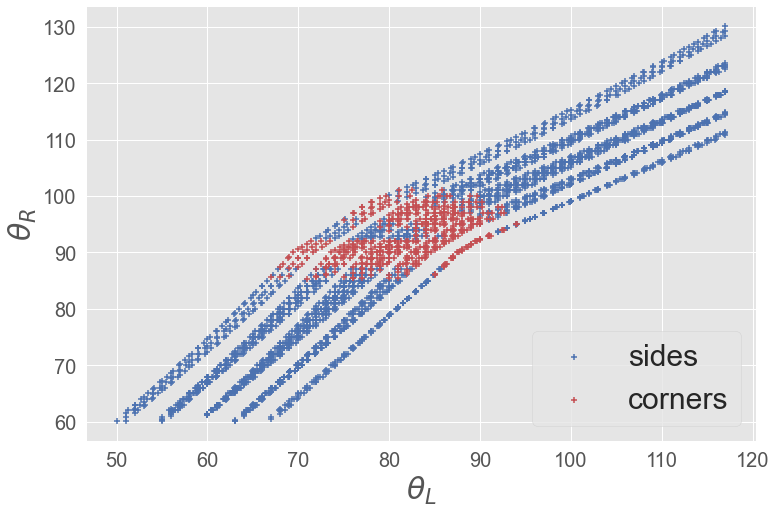

In [35]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1],color='b',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1],color='r',marker='+',label='corners')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("raw_data_window_manual_class.png")

# Standardizing the Data

In [36]:
def standardize_data(arr): 
    '''
    This function standardize an array, its substracts mean value, 
    and then divide the standard deviation.
    param 1: array 
    return: standardized array
    '''    
    rows, columns = arr.shape
    standardizedArray = np.zeros(shape=(rows, columns))
    tempArray = np.zeros(rows)
    for column in range(columns):  
        mean = np.mean(arr[:,column])
        std = np.std(arr[:,column])
        tempArray = np.empty(0)
        for element in arr[:,column]:
            tempArray = np.append(tempArray, ((element - mean) / std))
        standardizedArray[:,column] = tempArray
    return standardizedArray

# LDA with sklearn

In [37]:
# Preparation of the data for LDA
# Standardizing data
X = df.iloc[:, 0:-1].values
X_std = standardize_data(X)
le = LabelEncoder()
y = le.fit_transform(df['class'])
print("After formating the data we have: \n X = \n",X[:5],'\n y = \n', y)

# Import LDA from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_X = lda.fit_transform(X_std, y)
print("The explained variance ratio of lda is : ", lda.explained_variance_ratio_)

After formating the data we have: 
 X = 
 [[59.     60.     61.     62.     63.     60.0547 61.4128 62.773  64.1358
  65.5016]
 [60.     61.     62.     63.     64.     61.4128 62.773  64.1358 65.5016
  66.8709]
 [61.     62.     63.     64.     65.     62.773  64.1358 65.5016 66.8709
  68.2443]
 [62.     63.     64.     65.     66.     64.1358 65.5016 66.8709 68.2443
  69.6221]
 [63.     64.     65.     66.     67.     65.5016 66.8709 68.2443 69.6221
  71.0052]] 
 y = 
 [1 1 1 ... 1 1 1]
The explained variance ratio of lda is :  [1.]


# Plot projection on feature vectors

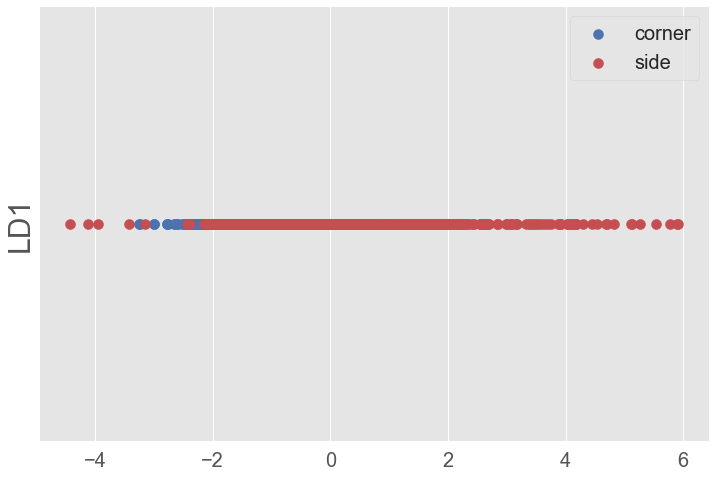

In [39]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LD1')
plt.scatter(lda_X[y==0], np.full((len(lda_X[y==0]),),1.0), s=100, color='b', label='corner')
plt.scatter(lda_X[y==1], np.full((len(lda_X[y==1]),),1.0), s=100, color='r', label='side')
plt.ylim(0.9,1.1)
ax.legend()

# Classification algorithm

In [40]:
from sklearn.cluster import KMeans

# 2-means clustering 
k2means = KMeans(n_clusters=2, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_k2means = k2means.fit_predict(lda_X)

# 3-mens clustering
k3means = KMeans(n_clusters=3, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_k3means = k3means.fit_predict(lda_X)

# Visualizing the clusters
## 2-means

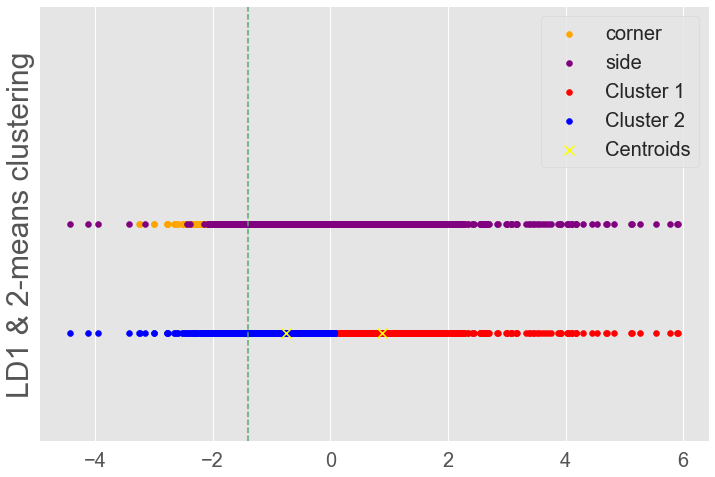

In [41]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LD1 & 2-means clustering')
plt.scatter(lda_X[y==0], np.full((len(lda_X[y==0]),),2), color='orange', label='corner')
plt.scatter(lda_X[y==1], np.full((len(lda_X[y==1]),),2), color='purple', label='side')
plt.scatter(lda_X[y_k2means==0], np.full((len(lda_X[y_k2means==0]),),1.0), c='red', label ='Cluster 1')
plt.scatter(lda_X[y_k2means==1], np.full((len(lda_X[y_k2means==1]),),1.0), c='blue', label ='Cluster 2')
plt.scatter(k2means.cluster_centers_[:, 0], np.full((len(k2means.cluster_centers_[:, 0]),),1.0), 
            s=100, c='yellow', marker='x',label = 'Centroids')
plt.plot([-1.4,-1.4],[0,4],'--',color='g')
plt.ylim(0,4)
ax.legend()
#plt.savefig('LD1_2_means_clustering.png')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.

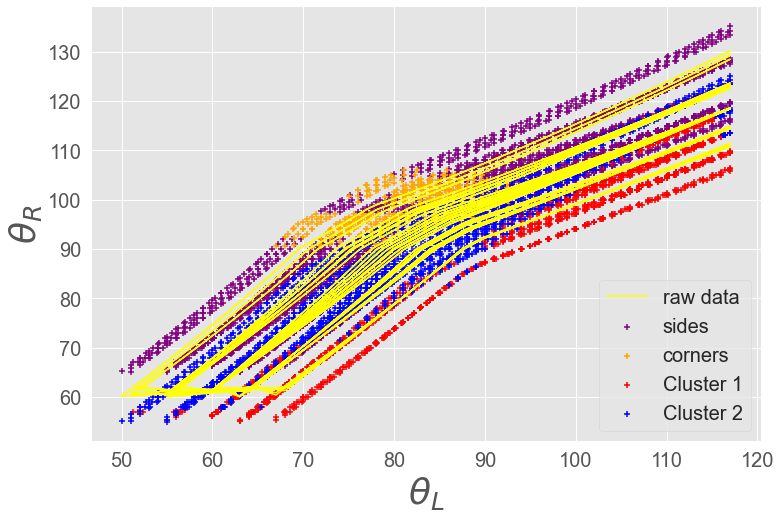

In [42]:
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='purple',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='orange',marker='+',label='corners')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k2means == 0], 
            angle_array[half_window_size:-half_window_size].T[1][y_k2means == 0]-5, 
            marker='+', c='red', label ='Cluster 1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k2means == 1], 
            angle_array[half_window_size:-half_window_size].T[1][y_k2means == 1]-5, 
            marker='+', c='blue', label ='Cluster 2')
plt.plot(angle_array[half_window_size:-half_window_size].T[0],
        angle_array[half_window_size:-half_window_size].T[1],
        color='yellow', label='raw data')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("clusters_class_raw_2_means.png")

## 3-means

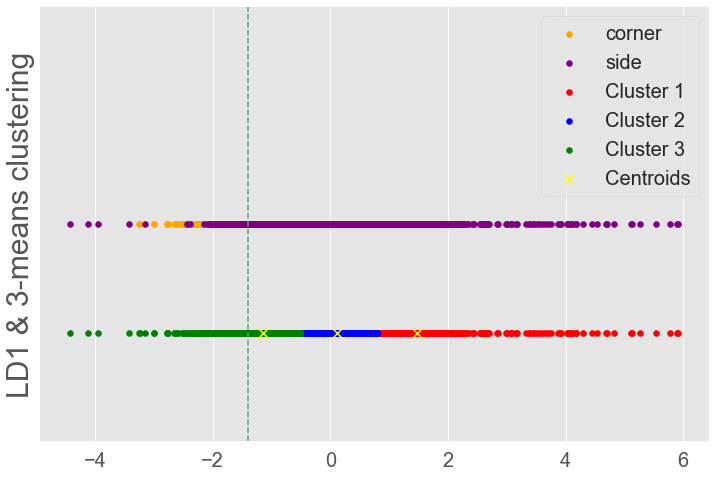

In [43]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LD1 & 3-means clustering')
plt.scatter(lda_X[y==0], np.full((len(lda_X[y==0]),),2), color='orange', label='corner')
plt.scatter(lda_X[y==1], np.full((len(lda_X[y==1]),),2), color='purple', label='side')
plt.scatter(lda_X[y_k3means==0], np.full((len(lda_X[y_k3means==0]),),1.0), c='red', label ='Cluster 1')
plt.scatter(lda_X[y_k3means==1], np.full((len(lda_X[y_k3means==1]),),1.0), c='blue', label ='Cluster 2')
plt.scatter(lda_X[y_k3means==2], np.full((len(lda_X[y_k3means==2]),),1.0), c='green', label ='Cluster 3')
plt.scatter(k3means.cluster_centers_[:, 0], np.full((len(k3means.cluster_centers_[:, 0]),),1.0), 
            s=100, c='yellow', marker='x',label = 'Centroids')
plt.plot([-1.4,-1.4],[0,4],'--',color='g')
plt.ylim(0,4)
ax.legend()
plt.savefig('LD1_3_means_clustering.png')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.


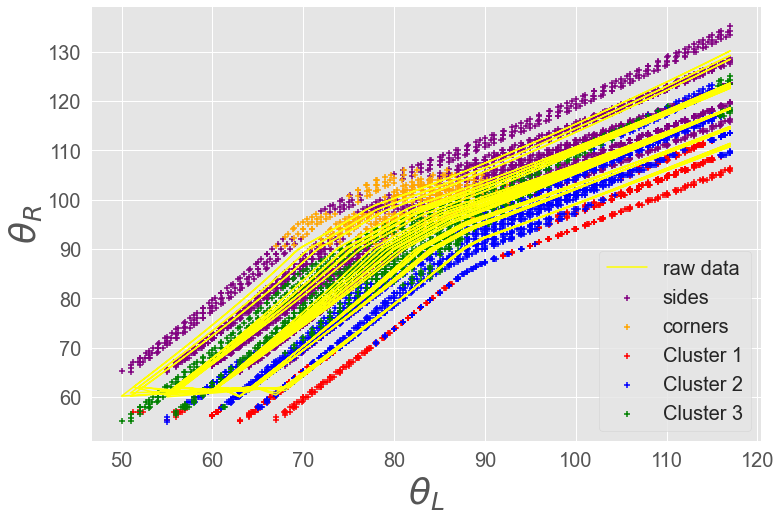

In [44]:
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='purple',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='orange',marker='+',label='corners')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 0], 
            angle_array[half_window_size:-half_window_size].T[1][y_k3means == 0]-5, 
            marker='+', c='red', label ='Cluster 1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 1], 
            angle_array[half_window_size:-half_window_size].T[1][y_k3means == 1]-5, 
            marker='+', c='blue', label ='Cluster 2')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 2], 
            angle_array[half_window_size:-half_window_size].T[1][y_k3means == 2]-5, 
            marker='+', c='green', label ='Cluster 3')
plt.plot(angle_array[half_window_size:-half_window_size].T[0],
        angle_array[half_window_size:-half_window_size].T[1],
        color='yellow', label='raw data')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
plt.savefig("clusters_class_raw_3_means.png")

# F1-score for k-means clustering
## 2-means clustering

In [45]:
" 0 : side ; 1 : corners"
from sklearn.metrics import f1_score
# we need to change "y" before beca
y_true = []
for i in range(y.shape[0]):
    if y[i] == 0:
        y_true += [1]
    else:
        y_true += [0]
print("The f1_score of the 2-means is : ",f1_score(y_true,y_k2means))

The f1_score of the 2-means is :  0.4157608695652174


## 3-means clustering

In [46]:
# f1-score on just the corner identification
y_k3_corner = []
for i in range(len(y_k3means.tolist())):
    if y_k3means[i] == 2:
        y_k3_corner += [1]
    else :
        y_k3_corner += [y_k3means[i]]
y_k3_corner = np.array(y_k3_corner)
print("The f1_score of the 2-means is : ",f1_score(y_true,y_k2means))
print("The f1_score of the 3-means for global corner identification is : ",f1_score(y_true,y_k3_corner))

from sklearn.metrics import accuracy_score
# f1-score on the number of corners
u = 0
v = 0
y_true_corners = []
for i in range(len(y_true)):
    if y_true[i] == 1 and v == 0:
        y_true_corners += [y_true[i]]
        u = 1
    elif y_true[i] == 0 and u==1:
        y_true_corners += [y_true[i]]
        v = 1
    elif y_true[i] == 1 and v==1:
        y_true_corners += [2]
    else:
        y_true_corners += [y_true[i]]

print("The f1_score of the 3-means for each corner identification (micro/or accuracy) is : ",
      accuracy_score(y_true_corners,y_k3means))

The f1_score of the 2-means is :  0.4157608695652174
The f1_score of the 3-means for global corner identification is :  0.3439575033200531
The f1_score of the 3-means for each corner identification (micro/or accuracy) is :  0.30658567774936063
